1:https://sourceforge.net/projects/tesseract-ocr.mirror/


2:https://github.com/oschwartz10612/poppler-windows/releases

In [1]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint

# Setting required paths related to library functions
POPPLER_PATH = r"C:\Users\kgopi\Downloads\Release-24.08.0-0\poppler-24.08.0\Library\bin"
TESSERACT_ENGINE_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = TESSERACT_ENGINE_PATH

In [2]:
# Path of prescription_doc file
DOC_PATH = r"C:\Users\kgopi\Downloads\model\pre_2.pdf"

In [3]:
# Converting pdf to images (function returns a PIL Image object)
pages = convert_from_path(DOC_PATH, poppler_path=POPPLER_PATH)
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

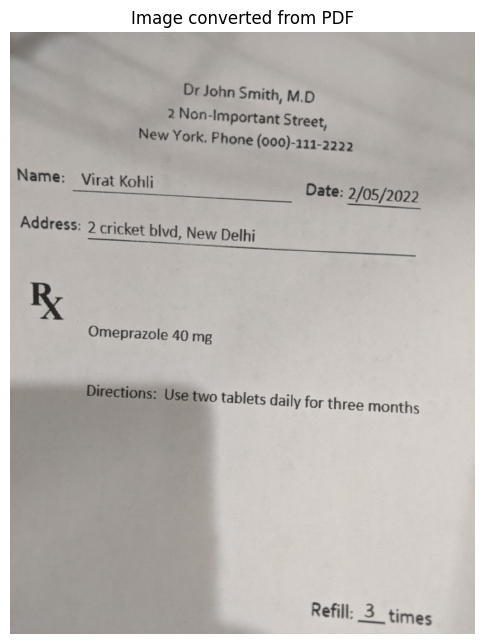

In [4]:
# Lets visualize our image
# pages[0].show() -> this PIL show() function opens image in a new window
plt.figure(figsize=(6,8))
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.show()

In [5]:
# Extract text from image using pytesseract
text = pytesseract.image_to_string(pages[0], lang="eng")
print(text)

Refill: 3 times




In [6]:
# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        63, # block size (after trial and error)
        12  # constant (after trial and error)
    )
    return processed_image

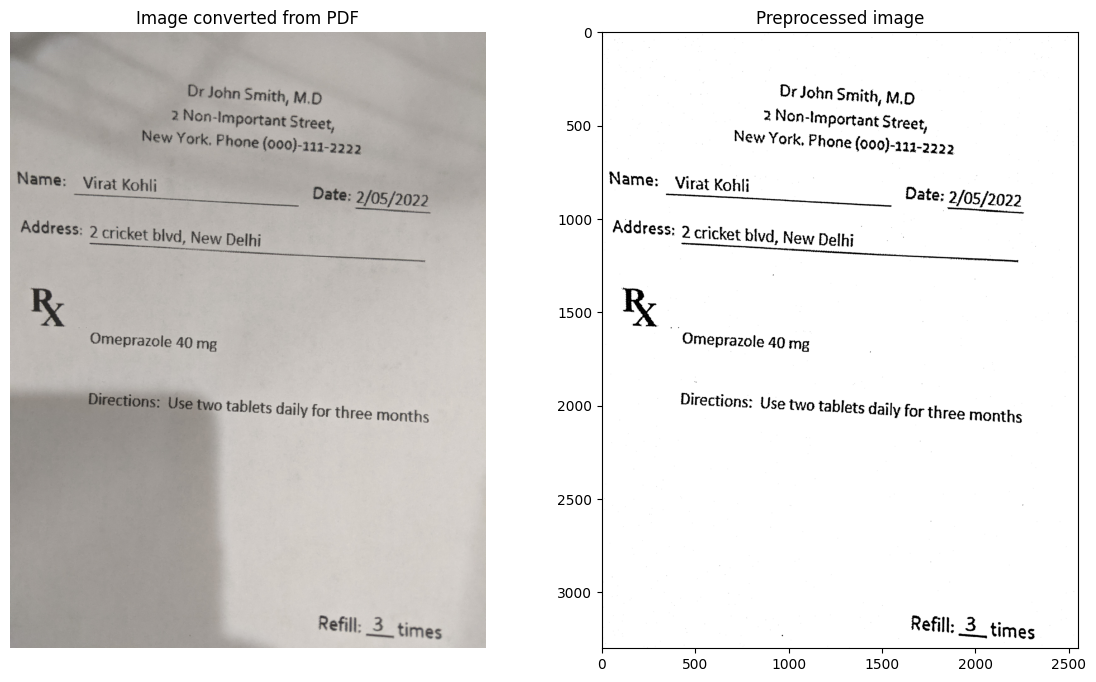

In [7]:
# Applying preprocessing on image
img = preprocess_image(pages[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()

In [8]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

Dr John Smith, M.D

2 Non-Important street,
New York, Phone (900)-12123- ~2222

Name:  Virat Kohli Date: 2/05/2022

Address: 2 cricket blvd, New Delhi

| Omeprazole 40 mg

Directions: Use two tablets daily for three months

Refill: 3 times



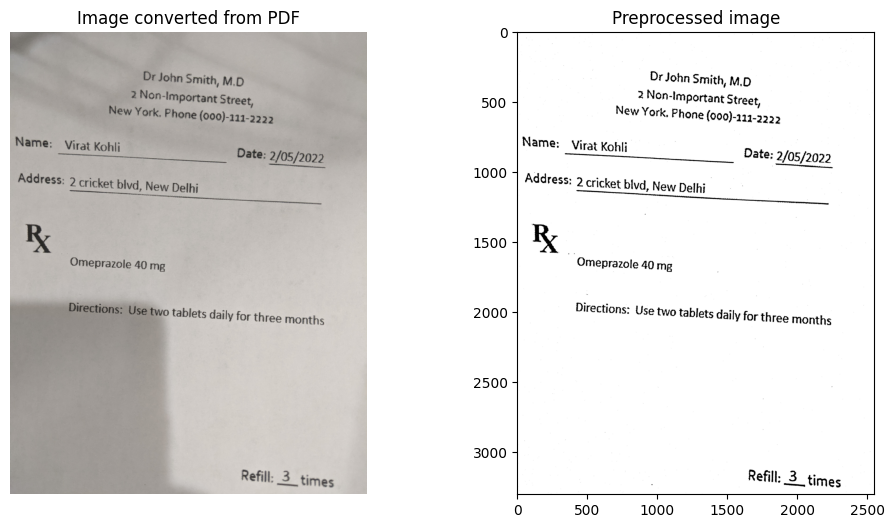

-----------------------------Text--------------------------------------
Dr John Smith, M.D

2 Non-Important street,
New York, Phone (900)-12123- ~2222

Name:  Virat Kohli Date: 2/05/2022

Address: 2 cricket blvd, New Delhi

| Omeprazole 40 mg

Directions: Use two tablets daily for three months

Refill: 3 times



In [10]:
# Let's try extracting text from our second prescription
DOC_PATH_1 = r"C:\Users\kgopi\Downloads\model\pre_2.pdf"
pages_1 = convert_from_path(DOC_PATH_1, poppler_path=POPPLER_PATH)
img = preprocess_image(pages_1[0])
# Visualize our images before and after preprocessing
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(pages_1[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()
print("-----------------------------Text--------------------------------------")
text_2 = pytesseract.image_to_string(img, lang="eng")
print(text_2)

In [11]:
# A function to return useful information in JSON format
def parse(text: str) -> Dict:
    return{
        "patient_name": get_field("patient_name", text),
        "patient_address": get_field("patient_address", text),
        "medicines": get_field("medicines", text),
        "directions": get_field("directions", text),
        "refill": get_field("refill", text)
    }        

# A function to find useful information from our text using Regular Expressions
def get_field(field_name: str, text: str) -> str:
    pattern_dict = {
        "patient_name": {"pattern": "Name:(.*)Date", "flags": 0},
        "patient_address": {"pattern": "Address:(.*)\n", "flags": 0},
        "medicines": {"pattern": "Address:[^\n]*(.*)Directions", "flags": re.DOTALL},
        "directions": {"pattern": "Directions:.(.*)Refill", "flags": re.DOTALL},
        "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},
    }

    pattern_object = pattern_dict.get(field_name)
    if pattern_object:
        matches = re.findall(pattern_object["pattern"], text, flags=pattern_object["flags"])
        if len(matches) > 0:
            return matches[0].strip()

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
C:\Users\kgopi\AppData\Local\Temp\ipykernel_25140\391750326.py:18: SyntaxWarning: invalid escape sequence '\d'
  "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},


In [12]:
# Let's get useful fields from our texts
text_list = [text_1, text_2]
for i in range(len(text_list)):
    print(f"Important fields from text {i+1}:\n")
    print(parse(text_list[i]))
    print("\n----------------------\n")

Important fields from text 1:

{'patient_name': 'Virat Kohli', 'patient_address': '2 cricket blvd, New Delhi', 'medicines': '| Omeprazole 40 mg', 'directions': 'Use two tablets daily for three months', 'refill': '3'}

----------------------

Important fields from text 2:

{'patient_name': 'Virat Kohli', 'patient_address': '2 cricket blvd, New Delhi', 'medicines': '| Omeprazole 40 mg', 'directions': 'Use two tablets daily for three months', 'refill': '3'}

----------------------

